In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import *

# plotting params
plt.rcParams['figure.figsize'] = (15.0, 8.0)
%matplotlib inline

In [2]:
cat_dir = './imgs/'

In [3]:
# grab all file names
included_extensions = ['png']
file_names = [fn for fn in os.listdir(cat_dir) 
                if any(fn.endswith(ext) for ext in included_extensions)]

In [4]:
# loop and convert to numpy array
imgs = []
for i in range(len(file_names)):
    filepath = os.path.join(cat_dir, file_names[i])
    imgs.append(img2array(filepath, desired_size=(1000, 1000)))
imgs = np.array(imgs)

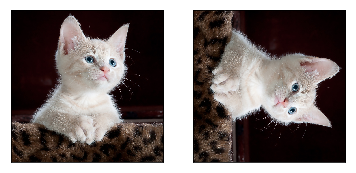

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)

for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
plt.show()